# 1. Context and data upload

Data comes from [Seattle Open Data](https://data.seattle.gov/Community/2021-Building-Energy-Benchmarking/bfsh-nrm6).

First step is to connect to the source. Since this data is available via the [Socrata Open Data API (SODA)](https://dev.socrata.com/), and the dataset contains 3663 rows, I indicate a max. value of rows to retrieve greater than 3663. Default value is [1000](https://dev.socrata.com/docs/paging.html).

In [1]:
import pandas as pd

link_source = 'https://data.seattle.gov/resource/bfsh-nrm6.csv'
rows_to_retrieve = '?$limit=5000'

init_data = pd.read_csv(link_source+rows_to_retrieve)

# Let's have a look at the shape:
print("This dataset contains {} rows and {} columns".format(
    init_data.shape[0], init_data.shape[1]))

This dataset contains 3663 rows and 42 columns


In [2]:
# Display all the columns for analysis
pd.set_option('display.max_columns', init_data.shape[1]+1)
# Set the column width (defaults to 50)
#pd.set_option('display.max_colwidth', 40)

init_data.head()

,osebuildingid,datayear,buildingname,buildingtype,taxparcelidentificationnumber,address,city,state,zipcode,latitude,longitude,neighborhood,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteeuiwn_kbtu_sf,siteeui_kbtu_sf,siteenergyuse_kbtu,siteenergyusewn_kbtu,sourceeuiwn_kbtu_sf,sourceeui_kbtu_sf,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,electricity_kwh,steamuse_kbtu,naturalgas_therms,compliancestatus,complianceissue,electricity_kbtu,naturalgas_kbtu,totalghgemissions,ghgemissionsintensity
0,1,2021,MAYFLOWER PARK HOTEL,NonResidential,659000030,405 OLIVE WAY,SEATTLE,WA,98101,47.61220,-122.33799,DOWNTOWN,1,1927,12,1,88434,88434,0,78,73.800003,73.599998,6510477,6522024,144.399994,144.199997,Hotel,Hotel,88434,NaN,0,NaN,0,944955,1798672,14876,Compliant,No Issue,3224187,1487620,241.6,2.7
1,2,2021,PARAMOUNT HOTEL,NonResidential,659000220,724 PINE ST,SEATTLE,WA,98101,47.61307,-122.33361,DOWNTOWN,1,1996,11,1,103566,88502,15064,96,52.200001,52.200001,4617104,4617104,99.099998,99.099998,Hotel,Hotel,88502,Parking,15064,NaN,0,657478,0,23738,Compliant,No Issue,2243315,2373790,135.4,1.5
2,3,2021,WESTIN HOTEL (Parent Building),NonResidential,659000475,1900 5TH AVE,SEATTLE,WA,98101,47.61367,-122.33822,DOWNTOWN,1,1969,41,3,956110,759392,196718,96,46.500000,46.500000,43953212,43953212,105.300003,105.300003,Hotel,Hotel,945349,Parking,117783,Swimming Pool,0,8673722,10583473,37750,Compliant,No Issue,29594739,3775000,1201.4,1.6
3,5,2021,HOTEL MAX,NonResidential,659000640,620 STEWART ST,SEATTLE,WA,98101,47.61412,-122.33664,DOWNTOWN,1,1926,10,1,61320,61320,0,76,79.500000,79.500000,4873753,4873753,136.000000,136.000000,Hotel,Hotel,61320,NaN,0,NaN,0,509497,1167770,19676,Compliant,No Issue,1738403,1967580,208.6,3.4
4,8,2021,WARWICK SEATTLE HOTEL,NonResidential,659000970,401 LENORA ST,SEATTLE,WA,98121,47.61375,-122.34047,DOWNTOWN,1,1980,18,1,175580,113580,62000,90,92.400002,92.000000,11358936,11409090,161.500000,161.100006,Hotel,Hotel,123445,Parking,68009,Swimming Pool,0,1333597,0,68087,Compliant,No Issue,4550233,6808700,380.4,3.3


# 2. Overview of the data and pre-selection of columns

First, it is important to note that only the __non-residential__ data should be used here (for this specific project).

The aim here is to predict the __CO2 emissions__ and the __total energy consumption__ for the non-residential buildings. It should be based on structural data (size and usage of the buildings, construction date, location, etc).
- It is interesting to note that: SiteEnergyUse(kBtu) ~= Electricity(kBtu) + SteamUse(kBtu) + NaturalGas(kBtu)
- The sum is not exactly equal (this can be verified by creating a calculated column), maybe there is some rounding errors.

It is also important to evalutate the __ENERGY STAR Score__'s utility here, and its predictive power.

In [3]:
init_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3663 entries, 0 to 3662
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   osebuildingid                   3663 non-null   int64  
 1   datayear                        3663 non-null   int64  
 2   buildingname                    3663 non-null   object 
 3   buildingtype                    3663 non-null   object 
 4   taxparcelidentificationnumber   3663 non-null   object 
 5   address                         3663 non-null   object 
 6   city                            3663 non-null   object 
 7   state                           3663 non-null   object 
 8   zipcode                         3663 non-null   int64  
 9   latitude                        3663 non-null   float64
 10  longitude                       3663 non-null   float64
 11  neighborhood                    3661 non-null   object 
 12  councildistrictcode             36

In [4]:
# First, let's remove the duplicate rows (if any).

# Make a copy:
copy_dedup = init_data.copy()

print(f'Rows before dedup: {init_data.shape[0]}')
# Ignore_index to reset the index:
copy_dedup.drop_duplicates(inplace=True, ignore_index=True)
print(f'Rows after dedup: {copy_dedup.shape[0]}')

Rows before dedup: 3663
Rows after dedup: 3663


There are none, great!

## 2.1. Selecting the non-residential rows

In [5]:
# Let's check the BuildingType
col_ = 'buildingtype'

init_data[col_].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [6]:
# Let's drop the rows that are residential
# I'm assuming SPS stands for Seattle Public Schools
to_drop = ['Multifamily MR (5-9)', 'Multifamily LR (1-4)',
           'Multifamily HR (10+)']

nonRes_data = init_data[~init_data[col_].isin(to_drop)]
nonRes_data.shape

(1700, 42)

In [7]:
# Quick check
nonRes_data[col_].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

## 2.2. Selecting the rows for CO2 emissions, total energy consumption and ENERGY STAR Score

In [8]:
# Define the variables to check for
co2_indic = 'totalghgemissions'
energy_indic = 'siteenergyuse_kbtu'
energy_star = 'energystarscore'

The indicator for the CO2 might not be the best one as-is since it also contains methane and nitrous oxide, but it's not  clear what to substract to get the exact value for the CO2 emissions here.

In [9]:
# Let's count how many rows contain at least 1 of the 3 variables empty
len(nonRes_data[nonRes_data[co2_indic].isna() |
                nonRes_data[energy_indic].isna() |
                nonRes_data[energy_star].isna()])

0

Looks like there are none, great!

## 2.3. Removing the columns related to the previously selected indicators to prevent data-leakage

In [10]:
dataleak_cols = ['siteeuiwn_kbtu_sf', 'siteeui_kbtu_sf', 'siteenergyusewn_kbtu',
                 'sourceeuiwn_kbtu_sf', 'sourceeui_kbtu_sf', 'electricity_kwh',
                 'steamuse_kbtu', 'naturalgas_therms', 'electricity_kbtu',
                 'naturalgas_kbtu', 'ghgemissionsintensity']

init_no_dl = nonRes_data.drop(columns=dataleak_cols)
init_no_dl.shape

(1700, 31)

## 2.4. 'Object' columns

In [11]:
# Now, let's investigate the 'object' columns for the modalities
obj_data = init_no_dl.select_dtypes(include='object')

# Print the shape and show a sample
print("This dataset contains {} rows and {} columns\n".format(
    obj_data.shape[0], obj_data.shape[1]))
obj_data.head()

This dataset contains 1700 rows and 13 columns



,buildingname,buildingtype,taxparcelidentificationnumber,address,city,state,neighborhood,epapropertytype,largestpropertyusetype,secondlargestpropertyusetype,thirdlargestpropertyusetype,compliancestatus,complianceissue
0,MAYFLOWER PARK HOTEL,NonResidential,659000030,405 OLIVE WAY,SEATTLE,WA,DOWNTOWN,Hotel,Hotel,NaN,NaN,Compliant,No Issue
1,PARAMOUNT HOTEL,NonResidential,659000220,724 PINE ST,SEATTLE,WA,DOWNTOWN,Hotel,Hotel,Parking,NaN,Compliant,No Issue
2,WESTIN HOTEL (Parent Building),NonResidential,659000475,1900 5TH AVE,SEATTLE,WA,DOWNTOWN,Hotel,Hotel,Parking,Swimming Pool,Compliant,No Issue
3,HOTEL MAX,NonResidential,659000640,620 STEWART ST,SEATTLE,WA,DOWNTOWN,Hotel,Hotel,NaN,NaN,Compliant,No Issue
4,WARWICK SEATTLE HOTEL,NonResidential,659000970,401 LENORA ST,SEATTLE,WA,DOWNTOWN,Hotel,Hotel,Parking,Swimming Pool,Compliant,No Issue


### Building Name

In [12]:
# This should not be relevant here, unless the aim is to "point out" some
# buildings that are "outliers" and help them reduce whatever is not good.
# I just count the number of different building names:
col_ = 'buildingname'

len(obj_data[col_].unique())

1669

Looks like there are some duplicates, it could be because it's a brand and they do not share the same address.

In [13]:
# Then, I drop the column:
sub_df_1 = init_no_dl.drop(columns=col_)
obj_data = obj_data.drop(columns=col_).copy()
sub_df_1.shape

(1700, 30)

### Tax Parcel ID

In [14]:
# Let's also count the number of different parcel ID:
col_ = 'taxparcelidentificationnumber'

len(obj_data[col_].unique())

1602

In [15]:
# Let's investigate some of the duplicates:
obj_data[obj_data.duplicated([col_])].head()

,buildingtype,taxparcelidentificationnumber,address,city,state,neighborhood,epapropertytype,largestpropertyusetype,secondlargestpropertyusetype,thirdlargestpropertyusetype,compliancestatus,complianceissue
109,NonResidential,7378600265,3802 S OTHELLO ST,SEATTLE,WA,GREATER DUWAMISH,Other - Lodging/Residential,Other - Lodging/Residential,Office,Food Service,Compliant,No Issue
128,NonResidential,3624039009,2600 SW BARTON ST,SEATTLE,WA,DELRIDGE NEIGHBORHOODS,Retail Store,Retail Store,NaN,NaN,Not Compliant,Portfolio Manager Account Not Shared
147,Nonresidential COS,7666205660,400 S SPOKANE ST,SEATTLE,WA,GREATER DUWAMISH,Other - Utility,Other - Utility,"Repair Services (Vehicle, Shoe, Locksmith, etc.)",NaN,Compliant,No Issue
197,NonResidential,9301500000,1601 5TH AVE,SEATTLE,WA,DOWNTOWN,Office,Office,Parking,NaN,Compliant,No Issue
252,NonResidential,2400002,1200 5TH AVE,SEATTLE,WA,DOWNTOWN,Office,Office,Parking,Other - Restaurant/Bar,Compliant,No Issue


In [16]:
# Pick one ID to investigate:
init_no_dl[init_no_dl[col_]=='3624039009']

,osebuildingid,datayear,buildingname,buildingtype,taxparcelidentificationnumber,address,city,state,zipcode,latitude,longitude,neighborhood,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,compliancestatus,complianceissue,totalghgemissions
127,223,2021,WESTWOOD VILLAGE - BLDG A,NonResidential,3624039009,2600 SW BARTON ST,SEATTLE,WA,98126,47.52254,-122.36627,DELRIDGE NEIGHBORHOODS,1,1966,1,1,64984,64984,0,0,2581250,Retail Store,Retail Store,65195,NaN,0,NaN,0,Not Compliant,Portfolio Manager Account Not Shared,41.8
128,224,2021,WESTWOOD VILLAGE - BLDG B,NonResidential,3624039009,2600 SW BARTON ST,SEATTLE,WA,98126,47.52254,-122.36627,DELRIDGE NEIGHBORHOODS,1,1965,1,1,67745,67745,0,0,7444998,Retail Store,Retail Store,67763,NaN,0,NaN,0,Not Compliant,Portfolio Manager Account Not Shared,339.9
2130,24636,2021,WESTWOOD VILLAGE - BUILDING E,NonResidential,3624039009,2600 SW BARTON ST,SEATTLE,WA,98126,47.52254,-122.36627,DELRIDGE NEIGHBORHOODS,1,1990,1,1,40265,40265,0,42,2452712,Retail Store,Retail Store,40793,NaN,0,NaN,0,Not Compliant,Portfolio Manager Account Not Shared,32.2
2131,24640,2021,WESTWOOD VILLAGE - BUILDING F,NonResidential,3624039009,2600 SW BARTON ST,SEATTLE,WA,98126,47.52254,-122.36627,DELRIDGE NEIGHBORHOODS,1,2005,1,1,26208,26208,0,74,1581233,Retail Store,Retail Store,32427,NaN,0,NaN,0,Not Compliant,Portfolio Manager Account Not Shared,35.3


This could be investigated further, but it looks like these are different buildings/parts of a building.

Also, this should not be a meaningful feature as-is, because each row has its own "energy use" value, so they can be considered separate.
- In case this assumption is wrong, add the feature back or find a way to create a new feature that could be used.

In [17]:
# I also remove this column:
sub_df_2 = sub_df_1.drop(columns=col_)
obj_data = obj_data.drop(columns=col_).copy()
sub_df_2.shape

(1700, 29)

### City
- Data comes from Seattle, so we expect this value

In [18]:
# Check the City
col_ = 'city'

obj_data[col_].unique()

array(['SEATTLE', '0', 'Seattle'], dtype=object)

In [19]:
# This is to be expected considering the data (from Seattle).
# I can drop this column:
sub_df_3 = sub_df_2.drop(columns=col_)
obj_data = obj_data.drop(columns=col_).copy()
sub_df_3.shape

(1700, 28)

### State
- Seattle is in Washington, so that's the value we expect

In [20]:
# Check the State
col_ = 'state'

obj_data[col_].unique()

array(['WA', '0'], dtype=object)

In [21]:
# Same thing as for the City here. I can drop this column:
sub_df_4 = sub_df_3.drop(columns=col_)
obj_data = obj_data.drop(columns=col_).copy()
sub_df_4.shape

(1700, 27)

### Neighborhood

In [22]:
# Check the Neighborhood
col_ = 'neighborhood'

obj_data[col_].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST',
       'SHARED: CENTRAL & EAST', 'NORTH', 'MAGNOLIA / QUEEN ANNE',
       'LAKE UNION', 'GREATER DUWAMISH', 'BALLARD', 'NORTHWEST',
       'CENTRAL', 'SOUTHWEST', 'DELRIDGE NEIGHBORHOODS',
       'SHARED: NORTH & NORTHWEST',
       'SHARED: GREATER DUWAMISH & DELRIDGE NEIGHBORHOODS',
       'SHARED: BALLARD & LAKE UNION', 'SHARED: LAKE UNION & NORTHWEST',
       'SHARED: BALLARD & NORTHWEST', 'water', nan], dtype=object)

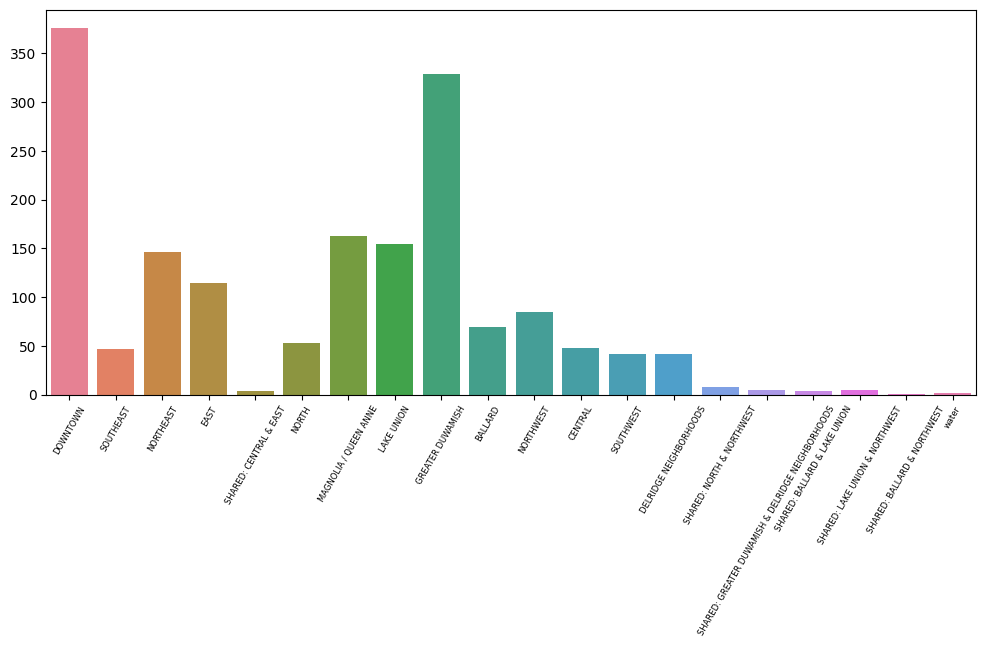

In [23]:
# Let's plot their repartition:
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensions of the plot
plt.rcParams['figure.figsize'] = (12,5)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Create the plot
sns.countplot(data=obj_data, x=col_, hue=col_, legend=False)
# Rotate the labels on x axis
plt.xticks(rotation=60, fontsize=6)
# Remove the 'titles' of the x and y axis
plt.xlabel('')
plt.ylabel('')
# Display
plt.show()

In [24]:
# To reduce the number of modalities, I group some of them:
grouped_ = 'SHARED_LOC'

conversion_dict = {
    'SHARED: CENTRAL & EAST': grouped_,
    'SHARED: NORTH & NORTHWEST': grouped_,
    'SHARED: GREATER DUWAMISH & DELRIDGE NEIGHBORHOODS': grouped_,
    'SHARED: BALLARD & LAKE UNION': grouped_,
    'SHARED: LAKE UNION & NORTHWEST': grouped_,
    'SHARED: BALLARD & NORTHWEST': grouped_,
    'water': 'WATER'
}

# Then apply the grouping:
sub_df_4[col_] = sub_df_4[col_].replace(conversion_dict).copy()
obj_data[col_] = obj_data[col_].replace(conversion_dict).copy()

In [25]:
# Actually, since this is a non structural column, I remove it
sub_df_5 = sub_df_4.drop(columns=col_)
obj_data = obj_data.drop(columns=col_).copy()
sub_df_5.shape

(1700, 26)

### EPAPropertyType (primary use of a property)

In [26]:
# Check the EPA
col_ = 'epapropertytype'

obj_data[col_].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Library', 'Fitness Center/Health Club/Gym', 'Mixed Use Property',
       'Courthouse', 'Prison/Incarceration', 'K-12 School',
       'College/University', 'Office', 'Self-Storage Facility',
       'Other - Mall', nan, 'Parking', 'Medical Office', 'Other',
       'Social/Meeting Hall', 'Performing Arts', 'Data Center',
       'Supermarket/Grocery Store', 'Multifamily Housing',
       'Hospital (General Medical & Surgical)', 'Fire Station', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Worship Facility', 'Other - Lodging/Residential',
       'Non-Refrigerated Warehouse', 'Retail Store', 'Financial Office',
       'Manufacturing/Industrial Plant', 'Other - Utility',
       'Residence Hall/Dormitory', 'Enclosed Mall', 'Laboratory',
       'Convention Center', 'Outpatient Rehabilitation/Physical Therapy',
       'Distribution Center', 'Other/Specialty Hospital',
       'Other - S

Here, I am using the grid from [this link](https://www.energystar.gov/buildings/benchmark/understand_metrics/what_eui) (ENERGYSTAR Score) to help remove the residential rows.

In [27]:
# That's a long list that I might rework (do some grouping), but not for now.
# I see some housing/residential related rows, let's investigate:

# Define the "abnormal" values:
residential_list = ['Barracks', 'Hotel', 'Multifamily Housing',
                    'Prison/Incarceration', 'Residence Hall/Dormitory',
                    'Residential Care Facility', 'Other - Lodging/Residential']

# Let's count how many rows there are, and show a sample:
print('There are {} abnormal rows\nHere\'s a sample:\n'.format(
    len(sub_df_5[sub_df_5[col_].isin(residential_list)])))
sub_df_5[sub_df_5[col_].isin(residential_list)].head()

There are 112 abnormal rows
Here's a sample:



,osebuildingid,datayear,buildingtype,address,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,compliancestatus,complianceissue,totalghgemissions
0,1,2021,NonResidential,405 OLIVE WAY,98101,47.61220,-122.33799,1,1927,12,1,88434,88434,0,78,6510477,Hotel,Hotel,88434,NaN,0,NaN,0,Compliant,No Issue,241.6
1,2,2021,NonResidential,724 PINE ST,98101,47.61307,-122.33361,1,1996,11,1,103566,88502,15064,96,4617104,Hotel,Hotel,88502,Parking,15064,NaN,0,Compliant,No Issue,135.4
2,3,2021,NonResidential,1900 5TH AVE,98101,47.61367,-122.33822,1,1969,41,3,956110,759392,196718,96,43953212,Hotel,Hotel,945349,Parking,117783,Swimming Pool,0,Compliant,No Issue,1201.4
3,5,2021,NonResidential,620 STEWART ST,98101,47.61412,-122.33664,1,1926,10,1,61320,61320,0,76,4873753,Hotel,Hotel,61320,NaN,0,NaN,0,Compliant,No Issue,208.6
4,8,2021,NonResidential,401 LENORA ST,98121,47.61375,-122.34047,1,1980,18,1,175580,113580,62000,90,11358936,Hotel,Hotel,123445,Parking,68009,Swimming Pool,0,Compliant,No Issue,380.4


In [28]:
# Without further knowledge, I'll assume this is a misclassification of the
# BuildingType and drop these rows:
sub_df_6 = sub_df_5[~sub_df_5[col_].isin(residential_list)]
obj_data = obj_data[~obj_data[col_].isin(residential_list)]
sub_df_6.shape

(1588, 26)

In [29]:
# I also replace the 'nan' by 'UNK' (Unknown)
sub_df_7 = sub_df_6.copy()
sub_df_7[col_] = sub_df_6[col_].fillna('UNK')
obj_data[col_] = obj_data[col_].fillna('UNK')

### Largest Property Use Type

In [30]:
# Check the Largest Property Use Type
col_ = 'largestpropertyusetype'

obj_data[col_].unique()

array(['Police Station', 'Other - Entertainment/Public Assembly',
       'Library', 'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'Courthouse', 'K-12 School', 'College/University', 'Office',
       'Self-Storage Facility', 'Other - Mall', 'Senior Living Community',
       'Parking', 'Medical Office', 'Other', 'Performing Arts',
       'Data Center', 'Supermarket/Grocery Store',
       'Hospital (General Medical & Surgical)', 'Fire Station', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc.)',
       'Worship Facility', 'Non-Refrigerated Warehouse', 'Retail Store',
       'Financial Office', 'Manufacturing/Industrial Plant',
       'Other - Utility', 'Transportation Terminal/Station', 'Laboratory',
       'Convention Center', 'Restaurant', 'Enclosed Mall', nan,
       'Outpatient Rehabilitation/Physical Therapy',
       'Distribution Center', 'Other/Specialty Hospital',
       'Other - Services', 'Strip Mall', 'Refrigerated Warehouse',
       'Urgent Ca

This list (as well as the 2nd and 3rd largest use type) should be aligned to the EPA Property Type (ideally). For now I'll just continue the analysis as-is, but this is a consideration for improvement.

In [31]:
# Same issue here.
# I see some housing/residential related rows, let's investigate:

# Define the "abnormal" values. Adding one more:
residential_list.append('Senior Living Community')

# Let's count how many rows there are, and show a sample:
print('There are {} abnormal rows\nHere\'s a sample:'.format(
    len(sub_df_7[sub_df_7[col_].isin(residential_list)])))
sub_df_7[sub_df_7[col_].isin(residential_list)].head()

There are 29 abnormal rows
Here's a sample:


,osebuildingid,datayear,buildingtype,address,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,compliancestatus,complianceissue,totalghgemissions
57,84,2021,NonResidential,4831 35TH AVE SW,98126,47.55837,-122.37751,1,1922,5,1,371257,296313,74944,44,44967996,UNK,Senior Living Community,296313,Parking,0,NaN,0,Compliant,No Issue,1862.0
58,85,2021,NonResidential,13023 GREENWOOD AVE N,98133,47.72426,-122.35599,1,1970,2,1,93397,93397,0,1,15596807,UNK,Senior Living Community,93397,NaN,0,NaN,0,Compliant,No Issue,571.8
163,278,2021,NonResidential,802 S DEARBORN ST,98134,47.59626,-122.32180,1,1999,5,1,102796,90185,12611,0,8770639,UNK,Senior Living Community,55259,Medical Office,40091,K-12 School,3231,Not Compliant,Default Data,133.9
864,20145,2021,NonResidential,909 BOREN AVE,98104,47.60897,-122.32507,3,2006,6,1,62334,51457,10877,0,2996646,UNK,Senior Living Community,47805,Parking,10877,Bank Branch,3552,Compliant,No Issue,53.5
941,20377,2021,NonResidential,2821 S WALDEN ST,98144,47.57188,-122.29531,1,1981,3,1,58665,58665,0,50,7595482,UNK,Senior Living Community,78374,Parking,0,NaN,0,Compliant,No Issue,237.4


In [32]:
# Without further knowledge, I'll assume this is a misclassification and
# drop these rows:
sub_df_8 = sub_df_7[~sub_df_7[col_].isin(residential_list)]
obj_data = obj_data[~obj_data[col_].isin(residential_list)]
sub_df_8.shape

(1559, 26)

In [33]:
# Check the missing values
sub_df_8[sub_df_8[col_].isna()].head()

,osebuildingid,datayear,buildingtype,address,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,compliancestatus,complianceissue,totalghgemissions
211,340,2021,NonResidential,600 1ST AVE,98104,47.60219,-122.33347,1,1900,6,1,89355,89355,0,0,0,UNK,NaN,0,NaN,0,NaN,0,Not Compliant,Portfolio Manager Account Not Shared,0.0
325,473,2021,NonResidential,500 BOREN AVE N,98109,47.62383,-122.33560,7,2009,5,1,271071,172371,98700,0,0,UNK,NaN,0,NaN,0,NaN,0,Contact the Help Desk,Unknown - Contact the Help Desk,0.0
352,514,2021,NonResidential,12525 AURORA AVE N,98133,47.72053,-122.34739,1,1997,1,1,131387,131387,0,0,0,UNK,NaN,0,NaN,0,NaN,0,Contact the Help Desk,Unknown - Contact the Help Desk,0.0
402,576,2021,NonResidential,818 NE NORTHGATE WAY,98125,47.70940,-122.31843,1,1969,2,1,98539,98539,0,0,0,UNK,NaN,0,NaN,0,NaN,0,Not Compliant,Portfolio Manager Account Not Shared,0.0
609,851,2021,NonResidential,2120 S JACKSON ST,98144,47.59970,-122.30364,1,1974,4,2,114000,114000,0,0,0,UNK,NaN,0,NaN,0,NaN,0,Not Compliant,Portfolio Manager Account Not Shared,0.0


In [34]:
# Since the EPA doesn't help, I also fill with UNK:
sub_df_9 = sub_df_8.copy()
sub_df_9[col_] = sub_df_8[col_].fillna('UNK')
obj_data[col_] = obj_data[col_].fillna('UNK')

### 2nd Largest Property Use Type

In [35]:
# Check the 2nd Largest Property Use Type
col_ = 'secondlargestpropertyusetype'

obj_data[col_].unique()

array(['Parking', nan, 'Office', 'Restaurant', 'Barracks', 'K-12 School',
       'Laboratory', 'Non-Refrigerated Warehouse', 'Other - Education',
       'Vocational School', 'Retail Store',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Medical Office', 'Performing Arts', 'Data Center',
       'Residence Hall/Dormitory', 'Distribution Center',
       'Repair Services (Vehicle, Shoe, Locksmith, etc.)',
       'Movie Theater', 'Multifamily Housing', 'Other',
       'Transportation Terminal/Station', 'Other - Services',
       'Other - Recreation', 'Food Service', 'College/University',
       'Hotel', 'Other - Restaurant/Bar', 'Supermarket/Grocery Store',
       'Adult Education', 'Fitness Center/Health Club/Gym',
       'Refrigerated Warehouse', 'Library',
       'Outpatient Rehabilitation/Physical Therapy',
       'Manufacturing/Industrial Plant', 'Social/Meeting Hall',
       'Enclosed Mall', 'Bar/Nightclub',
       'Other - Entertainment/Public Assembly', 'Self

In [36]:
# Same issue here.
# I see some housing/residential related rows, let's investigate:

# Let's count how many rows there are, and show a sample:
print('There are {} abnormal rows\nHere\'s a sample:'.format(
    len(sub_df_9[sub_df_9[col_].isin(residential_list)])))
sub_df_9[sub_df_9[col_].isin(residential_list)].head()

There are 18 abnormal rows
Here's a sample:


,osebuildingid,datayear,buildingtype,address,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,compliancestatus,complianceissue,totalghgemissions
20,26,2021,NonResidential,516 3RD AVE,98104,47.60265,-122.33051,1,1916,10,1,540360,540360,0,42,63318804,Courthouse,Courthouse,501287,Barracks,35863,NaN,0,Compliant,No Issue,1979.7
137,234,2021,Nonresidential COS,802 ROY ST,98109,47.62552,-122.34064,1,1926,2,1,50292,50292,0,0,0,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,38693,Residence Hall/Dormitory,5000,Office,4730,Compliant,No Issue,0.0
155,264,2021,NonResidential,516 1ST AVE W,98119,47.62390,-122.35756,1,2002,4,1,82061,42882,39179,0,7619336,Supermarket/Grocery Store,Supermarket/Grocery Store,76268,Multifamily Housing,72564,NaN,0,Not Compliant,Account Requires Verification,31.5
265,401,2021,NonResidential,1325 6TH AVE,98101,47.60968,-122.33379,1,1930,21,1,305548,305548,0,94,24048372,Fitness Center/Health Club/Gym,Fitness Center/Health Club/Gym,185292,Hotel,67822,Restaurant,31949,Not Compliant,Default Data,1216.6
467,657,2021,NonResidential,2200 WESTLAKE AVE,98121,47.61783,-122.33729,1,2006,0,1,516407,516407,0,93,34618024,Mixed Use Property,Parking,385196,Multifamily Housing,340236,Hotel,80067,Compliant,No Issue,1005.0


This part would definitely require domain knowledge on how to best handle these rows:
- they could be removed because we do not want any residential building at all,
- they could be removed based on a certain % of the total surface (say, if at least 20% is residential then the row gets removed),
- they could be kept because the main/largest use type is not residential,
- the residential part could be substracted from the total of each row, which would also require to deal with the energy/CO2 values of the rows (which _seems_ feasible but too complicated for now),
- etc

In [37]:
# For now, I just pick the easy way because it's only 18 rows. I drop them:
sub_df_10 = sub_df_9[~sub_df_9[col_].isin(residential_list)]
obj_data = obj_data[~obj_data[col_].isin(residential_list)]
sub_df_10.shape

(1541, 26)

In [38]:
# I also replace the 'nan' by 'UNK'
sub_df_11 = sub_df_10.copy()
sub_df_11[col_] = sub_df_10[col_].fillna('UNK')
obj_data[col_] = obj_data[col_].fillna('UNK')

### 3rd Largest Property Use Type

In [39]:
# Check for the completion of the column
col_ = 'thirdlargestpropertyusetype'

nb_na = sub_df_11[col_].isna().sum()
length = len(sub_df_11[col_])

print(f'Completion of the column: {(1 - nb_na/length) * 100:.2f}%')

Completion of the column: 21.16%


This column is too empty there, so I just drop it. I consider having enough information with the Largest and 2nd Largest Property Use Type, so I don't create a new column encoding the missingness.

In [40]:
# I also drop the related numeric column:
to_drop = ['thirdlargestpropertyusetype', 'thirdlargestpropertyusetypegfa']

sub_df_12 = sub_df_11.drop(columns=to_drop)
obj_data = obj_data.drop(columns='thirdlargestpropertyusetype')
sub_df_12.shape

(1541, 24)

### Compliance Status & Issue

In [41]:
# Check the Compliance Status
col_ = 'compliancestatus'

obj_data[col_].unique()

array(['Compliant', 'Not Compliant', 'Contact the Help Desk'],
      dtype=object)

In [42]:
# Check the Compliance Issue
col_ = 'complianceissue'

obj_data[col_].unique()

array(['No Issue', 'Portfolio Manager Account Not Shared',
       'Missing 2021 EUI or Electricity Data', 'Default Data',
       'Unknown - Contact the Help Desk', 'Account Requires Verification'],
      dtype=object)

In [43]:
# I'll assume these columns are not helpful for the prediction, so I drop them:
to_drop = ['compliancestatus', 'complianceissue']

sub_df_13 = sub_df_12.drop(columns=to_drop)
obj_data = obj_data.drop(columns=to_drop)
sub_df_13.shape

(1541, 22)

In [44]:
# Finally, let's reset the index
sub_df_14 = sub_df_13.reset_index(drop=True)

## 2.5. Numerical columns

In [45]:
# Let's select the non-'object' columns for the modalities
num_data = sub_df_14.select_dtypes(exclude='object')

# Print the shape and show a sample
print("This dataset contains {} rows and {} columns\n".format(
    num_data.shape[0], num_data.shape[1]))
num_data.head()

This dataset contains 1541 rows and 17 columns



,osebuildingid,datayear,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,largestpropertyusetypegfa,secondlargestpropertyuse,totalghgemissions
0,9,2021,98101,47.61623,-122.33657,1,1999,2,1,97288,60090,37198,0,9832419,50755,40971,196.0
1,11,2021,98101,47.61327,-122.33136,1,1926,8,1,102761,102761,0,0,7262585,102761,0,385.9
2,21,2021,98104,47.60649,-122.33297,1,2004,11,1,412000,355000,57000,0,13394116,364913,49000,108.3
3,22,2021,98104,47.60546,-122.33279,1,1930,6,1,103911,103911,0,0,7162932,61528,32195,263.7
4,24,2021,98104,47.60515,-122.33159,1,1907,5,1,57452,57452,0,0,6043709,16442,15505,223.8


In [46]:
# Define the (approx.) ratio to convert to m2:
sf_to_m2 = 10.76

### OSE Building ID (unique ID)

In [47]:
# Check the unique ID
col_ = 'osebuildingid'

# This should not throw an error (otherwise, there may be some duplicate issue):
assert len(num_data[col_].unique()) == num_data.shape[0]

In [48]:
# The column should not have any predictive power, and can/should be dropped:
sub_df_15 = sub_df_14.drop(columns=col_)
num_data = num_data.drop(columns=col_).copy()
sub_df_15.shape

(1541, 21)

### Data Year
- Data used is from 2021, so that's the value we expect

In [49]:
# Check the year
col_ = 'datayear'

num_data[col_].unique()

array([2021])

In [50]:
# This is to be expected considering the data. I can drop this column:
sub_df_16 = sub_df_15.drop(columns=col_)
num_data = num_data.drop(columns=col_).copy()
sub_df_16.shape

(1541, 20)

### Zipcode

In [51]:
# Check the Zipcode
col_ = 'zipcode'

num_data[col_].unique()

array([98101, 98104, 98118, 98121, 98112, 98125, 98109, 98103, 98105,
       98108, 98199, 98115, 98107, 98144, 98122, 98146, 98119, 98106,
       98133, 98126, 98134, 98117, 98136, 98116, 98177, 98102, 98155,
       98178, 98195,     0])

In [52]:
# Count the rows where the zipcode is '0' and display them:
print(
    f'There are {len(num_data[num_data[col_] == 0])} rows with 0 as Zipcode:\n')
num_data[num_data[col_]==0]

There are 13 rows with 0 as Zipcode:



,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,largestpropertyusetypegfa,secondlargestpropertyuse,totalghgemissions
1401,0,47.65034,-122.30907,1,1960,10,1,1739802,1615291,124511,59,325567936,1615291,124511,14619.9
1460,0,47.61523,-122.33835,1,2016,37,2,1496961,1076961,420000,95,45050740,1023298,448625,519.5
1461,0,47.64790,-122.33814,1,2016,4,1,338989,220902,118087,67,12152586,205727,117684,105.7
1462,0,47.70598,-122.33486,5,2016,2,1,44745,44745,0,95,1711505,44667,0,7.1
1465,0,47.61632,-122.33304,1,2016,21,1,489821,361575,128246,89,15805341,373458,110813,83.2
1466,0,47.66306,-122.30020,1,2016,4,1,47406,47406,0,11,2927390,45000,0,12.1
1467,0,47.66673,-122.38309,6,2016,4,1,37100,37100,0,93,1114496,34350,0,16.0
1468,0,47.63849,-122.37695,1,2016,1,1,25065,25065,0,98,1329135,25763,0,5.5
1469,0,47.70562,-122.32319,0,2005,1,1,20616,20616,0,0,557305,20616,0,2.3
1470,0,47.63191,-122.31523,0,1912,1,1,23445,23445,0,0,7361850,23445,0,364.9


In [53]:
# I could try to deduce the Zipcode through the address or the TaxParcelID,
# but I'll go with the easy (maybe not optimal) solution here: drop the rows:
# - review this (?) if I decide not to use the column later
sub_df_17 = sub_df_16[sub_df_16[col_]!=0]
num_data = num_data[num_data[col_]!=0].copy()
sub_df_17.shape

(1528, 20)

### Latitude and Longitude
* Latitude should range between -90 and +90
* Longitude should range between -180 and +180
* Seattle coordinates should be around lat. +47 / long. -122

In [54]:
col_lat = 'latitude'
col_long = 'longitude'

# Check the latitude
print('Latitude:\n- Min: {}\n- Max: {}'.format(num_data[col_lat].min(),
                                               num_data[col_lat].max()))
print('\nLongitude:\n- Min: {}\n- Max: {}'.format(num_data[col_long].min(),
                                                  num_data[col_long].max()))

Latitude:
- Min: 0.0
- Max: 47.73387

Longitude:
- Min: -122.41182
- Max: 0.0


In [55]:
# Let's investigate the rows where the Latitude is less than 45:
sub_df_17[sub_df_17[col_lat]<45]

,buildingtype,address,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions
1419,NonResidential,625 SW 100TH ST,98146,0.0,0.0,0,2010,2,1,44162,44162,0,0,1597700,Pre-school/Daycare,Pre-school/Daycare,44162,Parking,15761,36.7


In [56]:
# Let's also investigate the rows where the Longitude is greater than -120:
sub_df_17[sub_df_17[col_long]>-120]

,buildingtype,address,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions
1419,NonResidential,625 SW 100TH ST,98146,0.0,0.0,0,2010,2,1,44162,44162,0,0,1597700,Pre-school/Daycare,Pre-school/Daycare,44162,Parking,15761,36.7


In [57]:
# Looks like this row needs some fixing, but I'll just remove it:
sub_df_18 = sub_df_17[sub_df_17[col_lat]>45]
num_data = num_data[num_data[col_lat]>45].copy()
sub_df_18.shape

(1527, 20)

### CouncilDistrictCode

In [58]:
# Check the code
col_ = 'councildistrictcode'

num_data[col_].unique()

array([1, 7, 3, 4, 2, 6, 5])

Seems normal.

In [59]:
# Actually, since this is a non structural column, I remove it:
sub_df_19 = sub_df_18.drop(columns=col_)
num_data = num_data.drop(columns=col_).copy()
sub_df_19.shape

(1527, 19)

### Year Built

In [60]:
# Check the Year Built
col_ = 'yearbuilt'

num_data[col_].unique()

array([1999, 1926, 2004, 1930, 1907, 1961, 1928, 1955, 1949, 1989, 1906,
       1992, 1990, 1950, 1900, 1954, 1911, 1973, 1920, 1910, 1962, 2016,
       1965, 1983, 2010, 1938, 1986, 1970, 1923, 1908, 2003, 1991, 1957,
       1964, 1941, 1929, 1963, 1959, 1927, 1998, 2006, 1915, 2002, 2008,
       2001, 2000, 1958, 1980, 2011, 2007, 1951, 1953, 1996, 1952, 1904,
       1960, 1937, 1966, 1969, 1925, 1924, 1916, 1997, 1972, 2005, 1914,
       1995, 1968, 1981, 1978, 1976, 2009, 1922, 1909, 1971, 1988, 1979,
       1982, 1947, 1984, 1956, 1912, 1977, 1921, 1985, 1913, 1945, 1974,
       1975, 1994, 1946, 1967, 1987, 1932, 1948, 1993, 1918, 1905, 1931,
       1902, 1940, 1939, 1944, 1917, 1942, 1903, 2012, 2013, 1919, 2017,
       1901, 2019, 1936, 1935, 2014, 1896, 2015, 2018, 2020])

In [61]:
# Check for the min and max values
print('Construction year:\n- Oldest: {}\n- Most recent: {}'.format(
    num_data[col_].min(), num_data[col_].max()))

Construction year:
- Oldest: 1896
- Most recent: 2020


Seems normal.

### Number of floors

In [62]:
# Check the # of floors
col_ = 'numberoffloors'

num_data[col_].unique()

array([ 2,  8, 11,  6,  5,  7,  1,  3, 12,  4, 10, 15, 25, 33, 23, 17, 20,
       36, 16, 22, 47, 41, 29, 34, 14, 49, 37, 42, 63, 13, 18, 24, 21, 55,
       46, 30, 56,  9,  0, 19, 27, 76, 38])

In [63]:
# Check for the min and max values
print('Number of floors:\n- Min: {}\n- Max: {}'.format(
    num_data[col_].min(), num_data[col_].max()))

Number of floors:
- Min: 0
- Max: 76


In [64]:
# Count the rows where the # is '0' and display them:
print(
    f'There are {len(num_data[num_data[col_]==0])} rows with 0 as # of floors:\n')
num_data[num_data[col_]==0]

There are 9 rows with 0 as # of floors:



,zipcode,latitude,longitude,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,largestpropertyusetypegfa,secondlargestpropertyuse,totalghgemissions
398,98104,47.60979,-122.32298,2004,0,1,225982,225982,0,25,25412746,200184,0,1054.1
471,98101,47.61289,-122.33531,1999,0,1,947987,507802,440185,0,44423400,440185,339784,836.0
947,98104,47.60862,-122.32372,1975,0,1,383914,227569,156345,62,28010892,233491,135954,1459.8
1022,98134,47.59042,-122.32498,1991,0,10,230971,230971,0,0,42557948,196760,0,1762.7
1379,98115,47.68240,-122.26223,1960,0,1,30287,30287,0,94,2144492,28050,0,27.9
1380,98115,47.68254,-122.26299,1960,0,1,21931,21931,0,30,3996771,31845,0,158.3
1395,98115,47.68212,-122.26330,1929,0,7,564258,564258,0,0,20361622,564258,0,624.2
1428,98105,47.65644,-122.31041,1900,0,111,9320156,9320156,0,0,0,15216474,0,0.0
1520,98195,47.64846,-122.30003,1905,0,1,20904,20904,0,0,0,20904,0,0.0


In [65]:
# This seems to be a mistake. The value could either be 1, or 10, or something
# else that I could fill using an imputer, but for now I just drop these rows:
sub_df_20 = sub_df_19[sub_df_19[col_]!=0]
num_data = num_data[num_data[col_]!=0].copy()
sub_df_20.shape

(1518, 19)

### Number of buildings

In [66]:
# Check the # of buildings
col_ = 'numberofbuildings'

num_data[col_].unique()

array([ 1,  2,  0, 27, 10, 11, 16,  4,  8,  3,  6,  5, 39, 25, 14,  7])

In [67]:
# There are some abnormal values here. Let's check the value 0:
print(
    f'There are {len(num_data[num_data[col_]==0])} rows with 0 as # of buildings:\n')
num_data[num_data[col_]==0]

There are 18 rows with 0 as # of buildings:



,zipcode,latitude,longitude,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,largestpropertyusetypegfa,secondlargestpropertyuse,totalghgemissions
50,98126,47.53284,-122.37493,1926,3,0,44324,44324,0,0,1742902,50742,0,46.6
51,98119,47.65115,-122.36037,1927,2,0,82746,82746,0,0,8804385,82746,0,276.1
266,98109,47.62300,-122.35589,1964,4,0,127735,70135,57600,93,3414394,70135,61100,86.3
382,98104,47.59685,-122.33342,1904,4,0,83400,83400,0,0,0,83400,0,0.0
542,98144,47.58203,-122.29854,1972,1,0,166014,166014,0,39,5800354,166014,0,48.9
600,98101,47.61206,-122.33785,1926,4,0,27000,27000,0,0,2815636,16200,5400,53.0
627,98199,47.66304,-122.39169,1926,3,0,48560,48560,0,0,3059511,59805,0,12.7
635,98134,47.57411,-122.33715,1959,1,0,32192,32192,0,0,7123873,51442,168,304.3
683,98102,47.64596,-122.32628,1989,3,0,76245,42420,33825,57,2250568,41117,33825,9.3
738,98133,47.72362,-122.34897,1997,1,0,20595,20595,0,0,1656904,20595,0,62.8


In [68]:
# This seems to be a mistake. The value could either be 1, or 10, or something
# else that I could fill using an imputer, but for now I just drop these rows:
sub_df_21 = sub_df_20[sub_df_20[col_]!=0]
num_data = num_data[num_data[col_]!=0].copy()
sub_df_21.shape

(1500, 19)

### Property G<sub>*ross*</sub> F<sub>*loor*</sub> A<sub>*rea*</sub>
- Total
- Building(s)
- Parking

#### GFA total

In [69]:
# Select the GFA total
col_ = 'propertygfatotal'

# Check for the min and max values
print('Prop. GFA total:\n- Min: {:.2f} m2\n- Max: {:.2f} m2'.format(
    num_data[col_].min()/sf_to_m2,
    num_data[col_].max()/sf_to_m2))

Prop. GFA total:
- Min: 1858.74 m2
- Max: 195109.57 m2


#### GFA building(s)

In [70]:
# Select the GFA building(s)
col_ = 'propertygfabuilding_s'

# Check for the min and max values
print('Prop. GFA building(s):\n- Min: {:.2f} m2\n- Max: {:.2f} m2'.format(
    num_data[col_].min()/sf_to_m2,
    num_data[col_].max()/sf_to_m2))

Prop. GFA building(s):
- Min: 1063.20 m2
- Max: 188320.07 m2


#### GFA parking

In [71]:
# Select the GFA parking
col_ = 'propertygfaparking'

# Check for the min and max values
print('Prop. GFA parking:\n- Min: {:.2f} m2\n- Max: {:.2f} m2'.format(
    num_data[col_].min()/sf_to_m2,
    num_data[col_].max()/sf_to_m2))

Prop. GFA parking:
- Min: 0.00 m2
- Max: 63824.35 m2


#### Check that total = buildings + parking

In [72]:
# First make a copy of the data
pgfa_df = sub_df_21.copy()

In [73]:
p_total = 'propertygfatotal'
p_building = 'propertygfabuilding_s'
p_parking = 'propertygfaparking'

# Calculate the total of building + parking:
pgfa_df['computed_gfa_total'] = pgfa_df[p_building] + pgfa_df[p_parking]

In [74]:
# Now compare the two columns
sum(pgfa_df[p_total] != pgfa_df['computed_gfa_total'])

0

In [75]:
# # Since these columns carry the same information, I delete the total:
sub_df_22 = sub_df_21.drop(columns=p_total)
num_data = num_data.drop(columns=p_total).copy()
sub_df_22.shape

(1500, 18)

Great, there's no issue.

### EnergySTARScore

In [76]:
# Select the score
col_ = 'energystarscore'

# Check for the min and max values
print('EnergySTARScore:\n- Min: {}\n- Max: {}'.format(
    num_data[col_].min(), num_data[col_].max()))

EnergySTARScore:
- Min: 0
- Max: 100


Seems fine.

### Site Energy Use (kBtu)

In [77]:
# Select the Site Energy Use (kBtu)
col_ = 'siteenergyuse_kbtu'

# Check for the min and max values
print('Site Energy Use:\n- Min: {}\n- Max: {}'.format(
    num_data[col_].min(), num_data[col_].max()))

Site Energy Use:
- Min: 0
- Max: 518003488


In [78]:
# Check how many have no consumption:
len(sub_df_22[sub_df_22[col_]<1])

76

In [79]:
# Let's investigate a sample:
sub_df_22[sub_df_22[col_]<1].sample(n=5, random_state=23)

,buildingtype,address,zipcode,latitude,longitude,yearbuilt,numberoffloors,numberofbuildings,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions
559,NonResidential,9860 40TH AVE S,98118,47.51127,-122.28100,1967,1,1,48001,0,0,0,UNK,UNK,0,UNK,0,0.0
939,NonResidential,929 N 130TH ST,98133,47.72286,-122.34612,1979,2,1,20088,0,0,0,UNK,UNK,0,UNK,0,0.0
1098,NonResidential,3228 1ST AVE S,98134,47.57459,-122.33390,1937,1,1,20975,0,0,0,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,13144,Other,6600,0.0
1393,NonResidential,10020 MARTIN LUTHER KING JR WAY S,98178,47.51098,-122.27817,1988,2,8,293707,0,0,0,Self-Storage Facility,Self-Storage Facility,339027,Office,6000,0.0
299,NonResidential,5422 SHILSHOLE AVE NW,98107,47.66724,-122.38553,1941,2,1,63240,0,0,0,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,63240,UNK,0,0.0


In [80]:
# Most likely these buildings are abandonned (?), so I don't consider them:
sub_df_23 = sub_df_22[sub_df_22[col_]!=0]
num_data = num_data[num_data[col_]!=0].copy()
sub_df_23.shape

(1424, 18)

### Largest Property Use Type (GFA)

In [81]:
# Select the Largest Property Use Type (GFA)
col_ = 'largestpropertyusetypegfa'

# Check for the min and max values
print('Largest Prop. Use Type GFA:\n- Min: {:.2f} m2\n- Max: {:.2f} m2'.format(
    num_data[col_].min()/sf_to_m2,
    num_data[col_].max()/sf_to_m2))

Largest Prop. Use Type GFA:
- Min: 525.65 m2
- Max: 152354.46 m2


Seems fine.

### 2nd Largest Property Use Type (GFA)

In [82]:
# Select the 2nd Largest Property Use Type (GFA)
col_ = 'secondlargestpropertyuse'

# Check for the min and max values
print('Largest Prop. Use Type GFA:\n- Min: {:.2f} m2\n- Max: {:.2f} m2'.format(
    num_data[col_].min()/sf_to_m2,
    num_data[col_].max()/sf_to_m2))

Largest Prop. Use Type GFA:
- Min: 0.00 m2
- Max: 63824.35 m2


Seems ok.

### Total G<sub>*reen*</sub> H<sub>*ouse*</sub> G<sub>*as*</sub> emissions

In [83]:
# Select the Site Energy Use (kBtu)
col_ = 'totalghgemissions'

# Check for the min and max values
print('GHG emissions:\n- Min: {}\n- Max: {}'.format(
    num_data[col_].min(), num_data[col_].max()))

GHG emissions:
- Min: 0.6
- Max: 20445.7


In [84]:
# Check the very low values:
len(sub_df_23[sub_df_23[col_]<1])

9

In [85]:
# Let's have a look:
sub_df_23[sub_df_23[col_]<1]

,buildingtype,address,zipcode,latitude,longitude,yearbuilt,numberoffloors,numberofbuildings,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions
562,NonResidential,9840 40TH AVE S,98118,47.51127,-122.28100,1981,1,1,30375,0,94,152378,Distribution Center,Distribution Center,30375,UNK,0,0.6
703,NonResidential,4000 AURORA AVE N,98103,47.65570,-122.34682,1958,2,1,21436,0,100,168599,Office,Office,21436,UNK,0,0.7
708,NonResidential,1907 3RD AVE,98101,47.61165,-122.34011,1916,2,1,25920,0,81,206014,Retail Store,Retail Store,25920,UNK,0,0.9
766,NonResidential,832 NW 48TH ST,98107,47.66388,-122.36831,1960,1,1,36444,0,0,228108,Self-Storage Facility,Self-Storage Facility,36444,UNK,0,0.9
884,NonResidential,2400 W COMMODORE WAY,98199,47.66126,-122.38751,1965,1,1,23169,0,0,207174,Manufacturing/Industrial Plant,Manufacturing/Industrial Plant,10200,UNK,0,0.9
1241,NonResidential,10750 AURORA AVE N,98133,47.70833,-122.34429,1972,1,1,29400,0,85,146979,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,25000,UNK,0,0.6
1293,NonResidential,6540 5TH PL S,98108,47.54443,-122.32688,1976,1,1,21040,0,85,222000,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,21040,UNK,0,0.9
1310,NonResidential,8000 5TH AVE S,98108,47.53104,-122.32784,1977,1,1,24024,0,0,215528,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,14314,Other - Services,9710,0.9
1508,NonResidential,1625 W WHEELER ST,98119,47.64002,-122.37751,2019,1,1,24242,0,100,202840,Retail Store,Retail Store,21004,UNK,0,0.8


# 3. Data preparation

In [86]:
# Let's make a copy, while resetting the index
prep_df = sub_df_23.copy().reset_index(drop=True)

In [87]:
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   buildingtype                  1424 non-null   object 
 1   address                       1424 non-null   object 
 2   zipcode                       1424 non-null   int64  
 3   latitude                      1424 non-null   float64
 4   longitude                     1424 non-null   float64
 5   yearbuilt                     1424 non-null   int64  
 6   numberoffloors                1424 non-null   int64  
 7   numberofbuildings             1424 non-null   int64  
 8   propertygfabuilding_s         1424 non-null   int64  
 9   propertygfaparking            1424 non-null   int64  
 10  energystarscore               1424 non-null   int64  
 11  siteenergyuse_kbtu            1424 non-null   int64  
 12  epapropertytype               1424 non-null   object 
 13  lar

## 3.1. Outliers

### 3.1.1. Quantities

In [88]:
# Define the list of quantitative columns
quant_cols = ['numberoffloors', 'numberofbuildings', 'propertygfabuilding_s',
              'propertygfaparking', 'largestpropertyusetypegfa',
              'secondlargestpropertyuse']

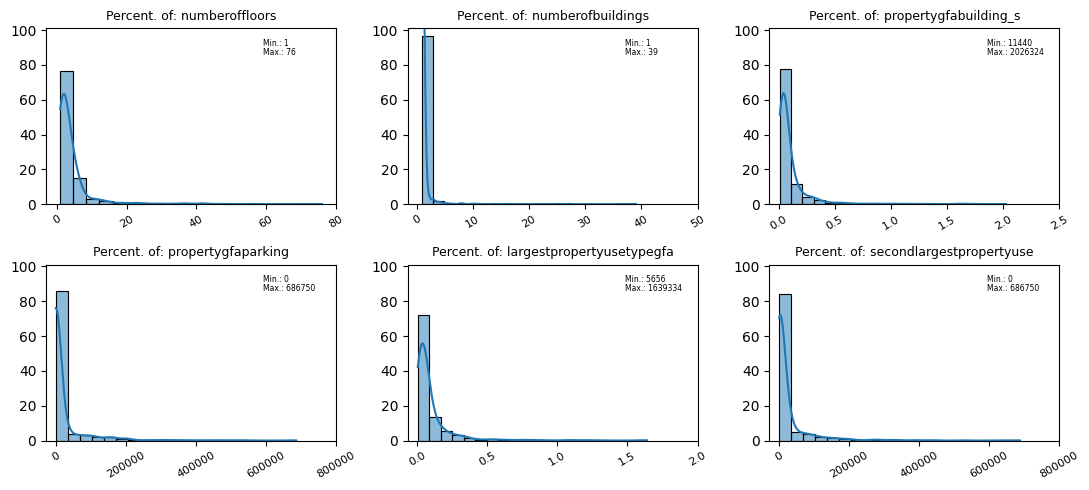

In [89]:
# Representing each variable with a histogram

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (11,5)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Plot for each column
_, axs = plt.subplots(2, 3)
for i in range(len(quant_cols)):
  sns.histplot(prep_df, x=quant_cols[i], stat='percent', bins=20, kde=True,
               ax=axs[i//3, i%3])
  # Remove x and y axis names
  axs[i//3, i%3].set(xlabel='', ylabel='')
  # Rotate x-ticks
  axs[i//3, i%3].set_xticks(axs[i//3, i%3].get_xticks(),
                            axs[i//3, i%3].get_xticklabels(),
                            rotation=30, fontsize=8)
  # Set the axis' limits
  axs[i//3, i%3].set_xlim(xmin=-prep_df[quant_cols[i]].max()*0.04)
  axs[i//3, i%3].set_ylim(ymax=101)
  # Set the column name as title
  axs[i//3, i%3].set_title('Percent. of: {}'.format(quant_cols[i]), fontsize=9)
  # Add min and max within the subplots
  axs[i//3, i%3].text(0.75, 0.9,
                      'Min.: {}'.format(prep_df[quant_cols[i]].min()),
                      fontsize=5.5, transform=axs[i//3, i%3].transAxes)
  axs[i//3, i%3].text(0.75, 0.85,
                      'Max.: {}'.format(prep_df[quant_cols[i]].max()),
                      fontsize=5.5, transform=axs[i//3, i%3].transAxes)
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

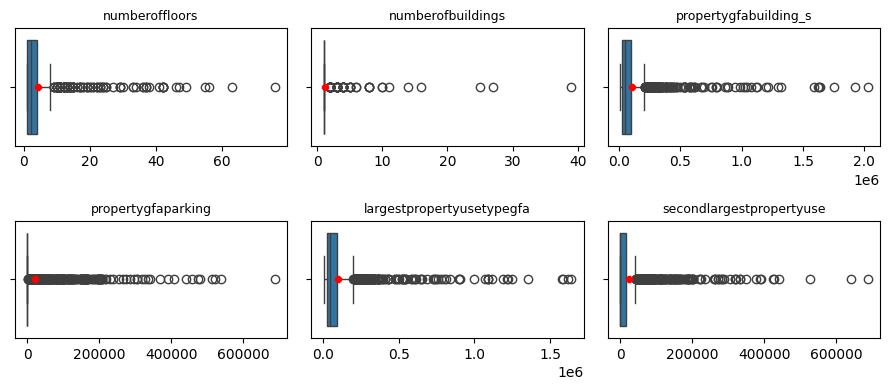

In [90]:
# Let's also represent these variables with a boxplot

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (9,4)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Plot for each column
_, axs = plt.subplots(2, 3)
for i in range(len(quant_cols)):
  sns.boxplot(prep_df, x=quant_cols[i], orient='h', ax=axs[i//3, i%3],
              showmeans=True, meanprops={'marker':'8',
                                         'markerfacecolor':'red',
                                         'markeredgecolor':'red',
                                         'markersize':'5'})
  # Remove x axis name
  axs[i//3, i%3].set(xlabel='')
  # Set the column name as title
  axs[i//3, i%3].set_title(quant_cols[i], fontsize=9)
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

## 3.2. Missing values

## 3.3. Encoding

## 3.4. Scaling

# 4. EDA